In [1]:
import sys
import os
path = os.getcwd()
dir = os.path.abspath(os.path.join(path, os.pardir))
sys.path.append(dir)

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

In [3]:
import numpy as np

In [4]:
from lenstronomy.LensModel.lens_model import LensModel
import lensinggw.constants.constants as const

In [5]:
from plot.plot import plot_contour
import amplification_factor.amplification_factor as af

In [6]:
G = const.G  # gravitational constant [m^3 kg^-1 s^-2]
c = const.c  # speed of light [m/s]
M_sun = const.M_sun  # Solar mass [Kg]

coordinates in scaled units [x (radians) /thetaE_tot]

In [7]:
y0, y1 = 0, 0 # source position
l0, l1 = 0., 0 # lens position

zS = 1.0 # source redshift
zL = 0.5 # lens redshift

In [8]:
mL = [1, 1.2, 0.8, 3]
mtot = sum(mL)

# convert to radians
from lensinggw.utils.utils import param_processing
thetaE1 = param_processing(zL, zS, mL[0])
thetaE2 = param_processing(zL, zS, mL[1])
thetaE3 = param_processing(zL, zS, mL[2])
thetaE4 = param_processing(zL, zS, mL[3])

thetaEl = [thetaE1, thetaE2]

thetaE = param_processing(zL, zS, mtot)

In [9]:
beta0, beta1 = 0, 0
eta10, eta11 = 0.2 * thetaE1, 0 * thetaE1
eta20, eta21 = -0.3 * thetaE2, 0 * thetaE2
# eta30, eta31 = 0 * thetaE3, -0.1 * thetaE3
# eta40, eta41 = 0 * thetaE4, 0.1 * thetaE4


In [10]:
lens_model_list = ['POINT_MASS', 'POINT_MASS']
kwargs_pm_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_pm_2 = {'center_x': eta20, 'center_y': eta21, 'theta_E': thetaE2}
# kwargs_pm_3 = {'center_x': eta30, 'center_y': eta31, 'theta_E': thetaE3}
# kwargs_pm_4 = {'center_x': eta40, 'center_y': eta41, 'theta_E': thetaE4}

kwargs_lens_list = [kwargs_pm_1, kwargs_pm_2]

In [11]:
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(beta0, beta1, kwargs_lens_list, beta0, beta1)#[0]
Tscale = 4 * (1 + zL) * mtot * M_sun * G / c ** 3
print('T0 = {}'.format(T0))
print('Tscale = {}'.format(Tscale))

T0 = 9.857298509180655
Tscale = 0.0001773176769195687


In [12]:
kwargs_macro = {'source_pos_x': beta0,
                'source_pos_y': beta1,
                'theta_E': thetaE
               }

In [20]:
# Define the characteristic WindowSize
# mL2 = 10
# thetaE2 = param_processing(zL, zS, mL2)

kwargs_integrator = {'PixelNum': int(50000),          # Number of pixels on each side of the window
                     'PixelBlockMax': 2000,           # Dividing PixelNum into PixelBlock
                     'WindowSize': 200*max(thetaEl), 
                     'WindowCenterX': eta10, 
                     'WindowCenterY': eta11,
                     'T0': T0,                        # Time delay of the reference point (WindowCenter)
                     'TimeStep': 1e-5/Tscale,         # integration step in time domain
                     'TimeMax': T0 + .5/Tscale,        # Upper bound of time integration
                     'TimeMin': T0 - 10/Tscale,       # Lower bound of time integration
                     'TimeLength': 10/Tscale,          
                     'TExtend': 10/Tscale,            # Extend the time domain curve to desired time. In this example, it is extended to T0+10 seconds 
                     'Tscale': Tscale}                

start


Integrating...: 100%|██████████| 676/676 [07:10<00:00,  1.57it/s]


999990 14516 trim


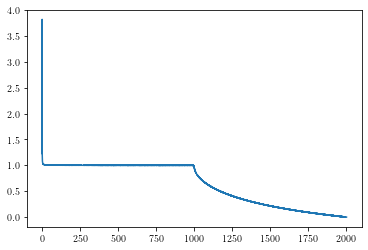

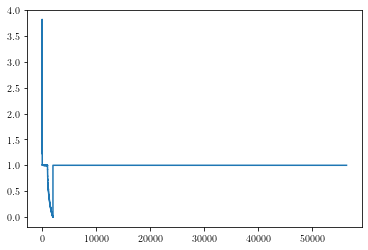

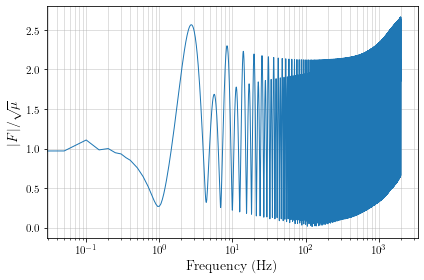

In [21]:
amplification = af.amplification_factor_fd(lens_model_list=lens_model_list, kwargs_lens=kwargs_lens_list, kwargs_macro=kwargs_macro, **kwargs_integrator)
ws, Fws = amplification.integrator(embedded=False, plot=True)
amplification.plot()

/tmp/ipykernel_827/3287567560.py:46: RuntimeWarning: invalid value encountered in multiply
  return 0.5*wj(f, xi_0, zL, DS, DL, DLS)*(np.pi-1j*(2*np.log(Y)-sc.expi(1j*wj(f, xi_0, zL, DS, DL, DLS)*Y**2 /2)))


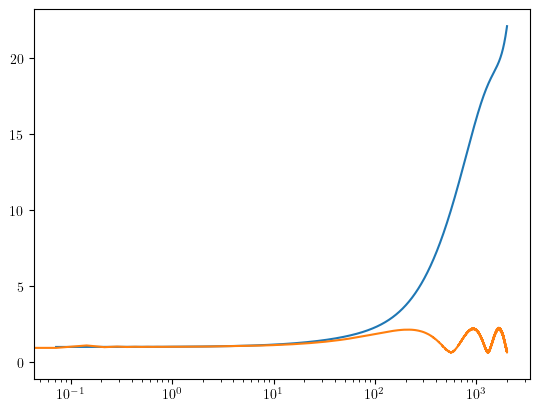

In [22]:
import scipy.special as sc
from matplotlib import pyplot as plt
from astropy.cosmology import Planck18

from pycbc.waveform import td_approximants, fd_approximants
from pycbc import types, fft, waveform

#setting up geometrized units
meter = 1
Mpc = 3.086e22*meter
solarmass = 1480*meter
Hz = 1/(3 * 10**8)

zL = 0.5
zS = 1

#some angular diameter distances
DS = Planck18.angular_diameter_distance(zS).value*Mpc
DL = Planck18.angular_diameter_distance(zL).value*Mpc
DLS = Planck18.angular_diameter_distance_z1z2(zL, zS).value*Mpc



#eta: source position
eta=[0,0]

#N: number of point masses in the lens system
N = 1

#mass of each point mass
mj = np.array([100*solarmass])

total_mass=np.sum(mj)

#einstein radius of each point mass
xi_0j = 2*np.sqrt(mj*DL*DLS/DS)

def omega(f):
    return 2*np.pi*f

#dimensionless frequency function for each point mass
def wj(f, xi_0, zL, DS, DL, DLS):
    return (1+zL)*omega(f)*xi_0**2 *DS/(DL*DLS)

def first_order_F(f, xi_0, zL, DS, DL, DLS, Y):
    return 0.5*wj(f, xi_0, zL, DS, DL, DLS)*(np.pi-1j*(2*np.log(Y)-sc.expi(1j*wj(f, xi_0, zL, DS, DL, DLS)*Y**2 /2)))

def F(f, xi_0j, zL, DS, DL, DLS, Yj):
    #somehow using np.sum would not work!!!
    return 1 + sum([first_order_F(f, xi_0j[j], zL, DS, DL, DLS, Yj[j]) for j in range(N)])

#to edit the position of the pml, please modify jth_lens_pos_setup(n)=[[x1,y1],[x2,y2],...]
#Setup1
jth_lens_pos_setup1=[[0.5*xi_0j[0],0]]
Yjsetup1 = [np.sqrt((jth_lens_pos_setup1[j][0]-eta[0]*DL/DS)**2+(jth_lens_pos_setup1[j][1]-eta[1]*DL/DS)**2)/xi_0j[j] for j in range(N)]


#Setup2
jth_lens_pos_setup2=[[0.5*xi_0j[0],0]]
Yjsetup2 = [np.sqrt((jth_lens_pos_setup2[j][0]-eta[0]*DL/DS)**2+(jth_lens_pos_setup2[j][1]-eta[1]*DL/DS)**2)/xi_0j[j] for j in range(N)]


#Setup3
jth_lens_pos_setup3=[[0.5*xi_0j[0],0]]
Yjsetup3 = [np.sqrt((jth_lens_pos_setup3[j][0]-eta[0]*DL/DS)**2+(jth_lens_pos_setup3[j][1]-eta[1]*DL/DS)**2)/xi_0j[j] for j in range(N)]

x = ws/(2*np.pi)
plt.semilogx(x, np.absolute(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup1)))
# plt.semilogx(x, np.absolute(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup2)))
# plt.semilogx(x, np.absolute(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup3)))
plt.semilogx(x, np.abs(Fws))
plt.show()